# Feature Engineering

This notebook covers:

Geolocation Analysis: Converting IP addresses to integers and mapping to countries

Time-Based Features: Creating hour_of_day, day_of_week, and time_since_signup

Transaction Frequency: User and device transaction counts, purchase patterns

Behavioral Features: Age groups, purchase categories, weekend/night indicators




In [11]:
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Load the cleaned data
print("Loading cleaned datasets...")
fraud_df = pd.read_csv(r'C:\Users\Antifragile\Desktop\Fraud_detection\data\Fraud_Data.csv')
creditcard_df = pd.read_csv(r'C:\Users\Antifragile\Desktop\Fraud_detection\data\clean\final_creditcard.csv')
ip_map_df= pd.read_csv(r'C:\Users\Antifragile\Desktop\Fraud_detection\data\clean\final_ip_map.csv')

print(f"Fraud data shape: {fraud_df.shape}")
print(f"Credit card data shape: {creditcard_df.shape}")
print(f"IP country data shape: {ip_map_df.shape}")

Loading cleaned datasets...
Fraud data shape: (151112, 11)
Credit card data shape: (283726, 31)
IP country data shape: (138846, 3)


#GEOLOCATION ANALYSIS - Merging IP addresses with countries

In [12]:
print(fraud_df['ip_address'].head(10))
print(fraud_df['ip_address'].dtype)


0    7.327584e+08
1    3.503114e+08
2    2.621474e+09
3    3.840542e+09
4    4.155831e+08
5    2.809315e+09
6    3.987484e+09
7    1.692459e+09
8    3.719094e+09
9    3.416747e+08
Name: ip_address, dtype: float64
float64


In [14]:
from ipaddress import ip_address

# Convert float IPs to integers safely
fraud_df = fraud_df.dropna(subset=['ip_address'])
fraud_df['ip_int'] = fraud_df['ip_address'].astype(np.uint32)
fraud_df['ip_str'] = fraud_df['ip_int'].apply(lambda x: str(ip_address(x)))

# Prepare the ip_country_df for range-based merging
ip_map_df['lower_bound_ip_address'] = ip_map_df['lower_bound_ip_address'].astype(np.uint32)
ip_map_df['upper_bound_ip_address'] = ip_map_df['upper_bound_ip_address'].astype(np.uint32)

# Sort both DataFrames for merge_asof
ip_map_df = ip_map_df.sort_values('lower_bound_ip_address')
fraud_df = fraud_df.sort_values('ip_int')

# Use pandas merge_asof to get the lower bound
merged_df = pd.merge_asof(
    fraud_df,
    ip_map_df[['lower_bound_ip_address', 'upper_bound_ip_address', 'country']],
    left_on='ip_int',
    right_on='lower_bound_ip_address',
    direction='backward'
)

# Filter only rows where ip_int <= upper_bound (valid match)
merged_df = merged_df[merged_df['ip_int'] <= merged_df['upper_bound_ip_address']]

# Bin countries with <1% frequency into 'Other'
country_counts = merged_df['country'].value_counts()
threshold = len(merged_df) * 0.01  # 1% threshold
top_countries = country_counts[country_counts >= threshold].index
merged_df['country_binned'] = merged_df['country'].where(merged_df['country'].isin(top_countries), 'Other')

# Result
print("Sample mapped results:")
print(merged_df[['ip_int', 'ip_str', 'country']].head())

print("\nTop countries:")
print(merged_df['country'].value_counts().head(10))

print("\nBinned countries:")
print(merged_df['country_binned'].value_counts().head())

Sample mapped results:
       ip_int       ip_str    country
634  16778864    1.0.6.112  Australia
635  16842045   1.0.253.61   Thailand
636  16843656    1.1.3.136      China
637  16938732  1.2.118.236      China
638  16971984  1.2.248.208   Thailand

Top countries:
United States        58049
China                12038
Japan                 7306
United Kingdom        4490
Korea Republic of     4162
Germany               3646
France                3161
Canada                2975
Brazil                2961
Italy                 1944
Name: country, dtype: int64

Binned countries:
United States     58049
Other             21964
China             12038
Japan              7306
United Kingdom     4490
Name: country_binned, dtype: int64


In [15]:
# After merging and filtering
fraud_data = merged_df.copy()

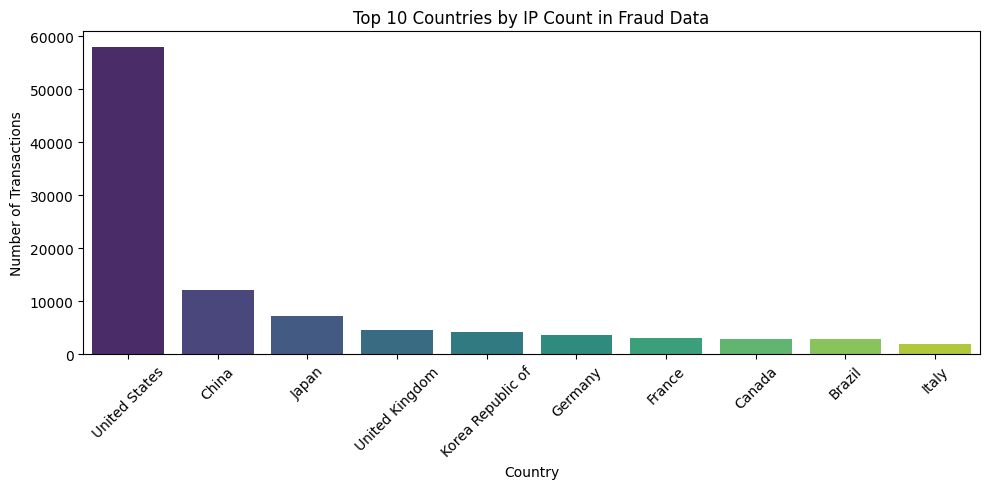

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

top_countries = merged_df['country'].value_counts().head(10)
plt.figure(figsize=(10, 5))
sns.barplot(x=top_countries.index, y=top_countries.values, palette="viridis")
plt.title("Top 10 Countries by IP Count in Fraud Data")
plt.ylabel("Number of Transactions")
plt.xlabel("Country")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Check Fraud Rate by Country

In [17]:
# class = 1 means fraud
country_fraud = merged_df.groupby('country')['class'].agg(['count', 'sum', 'mean'])
country_fraud['fraud_rate'] = country_fraud['mean'] * 100
country_fraud = country_fraud.sort_values(by='fraud_rate', ascending=False).head(10)

print(country_fraud[['count', 'sum', 'fraud_rate']])


                       count  sum  fraud_rate
country                                      
Turkmenistan               1    1  100.000000
Namibia                   23   10   43.478261
Sri Lanka                 31   13   41.935484
Luxembourg                72   28   38.888889
Virgin Islands (U.S.)      3    1   33.333333
Ecuador                  106   28   26.415094
Tunisia                  118   31   26.271186
Peru                     119   31   26.050420
Bolivia                   53   13   24.528302
Kuwait                    90   21   23.333333


#TIME-BASED FEATURE ENGINEERING

In [18]:
# Convert time columns to datetime
print("Converting time columns to datetime...")
fraud_data['signup_time'] = pd.to_datetime(fraud_data['signup_time'])
fraud_data['purchase_time'] = pd.to_datetime(fraud_data['purchase_time'])

Converting time columns to datetime...


In [33]:
# Convert to datetime format 
fraud_data['purchase_time'] = pd.to_datetime(fraud_data['purchase_time'])
fraud_data['signup_time'] = pd.to_datetime(fraud_data['signup_time'])

# Extract base time features 
fraud_data['hour_of_day'] = fraud_data['purchase_time'].dt.hour
fraud_data['day_of_week'] = fraud_data['purchase_time'].dt.dayofweek  # 0=Mon, 6=Sun
fraud_data['time_since_signup'] = (
    fraud_data['purchase_time'] - fraud_data['signup_time']
).dt.total_seconds() / 3600  # In hours

# Create raw binned versions for interpretability (e.g., SHAP plots)
fraud_data['hour_of_day_binned_raw'] = pd.cut(
    fraud_data['hour_of_day'], bins=[0, 6, 12, 18, 24],
    labels=['Night', 'Morning', 'Afternoon', 'Evening'], include_lowest=True
)
fraud_data['day_part_raw'] = pd.cut(
    fraud_data['hour_of_day'], bins=[0, 6, 12, 18, 24],
    labels=['Night', 'Morning', 'Afternoon', 'Evening'], include_lowest=True
)

# Derived binary and categorical features 
fraud_data['hour_of_day_binned'] = fraud_data['hour_of_day_binned_raw']
fraud_data['day_part'] = fraud_data['day_part_raw']
fraud_data['is_night_purchase'] = ((fraud_data['hour_of_day'] >= 20) | (fraud_data['hour_of_day'] < 6)).astype(int)
fraud_data['is_peak_hour'] = ((fraud_data['hour_of_day'] >= 9) & (fraud_data['hour_of_day'] <= 17)).astype(int)
fraud_data['is_business_day'] = fraud_data['day_of_week'].isin([0, 1, 2, 3, 4]).astype(int)

# One-hot encode binned time features for modeling
fraud_data = pd.get_dummies(fraud_data, columns=['hour_of_day_binned', 'day_part'], drop_first=True)

# Sanity check
print("✅ Time-based features created successfully!")
print("Sample columns now include:", [col for col in fraud_data.columns if 'hour_of_day' in col or 'day' in col or 'time' in col])


✅ Time-based features created successfully!
Sample columns now include: ['signup_time', 'purchase_time', 'hour_of_day', 'day_of_week', 'time_since_signup', 'is_business_day', 'hour_of_day_binned_Morning', 'hour_of_day_binned_Afternoon', 'hour_of_day_binned_Evening', 'day_part_Morning', 'day_part_Afternoon', 'day_part_Evening', 'hour_of_day_binned_raw', 'day_part_raw', 'hour_of_day_binned_Morning', 'hour_of_day_binned_Afternoon', 'hour_of_day_binned_Evening', 'day_part_Morning', 'day_part_Afternoon', 'day_part_Evening']


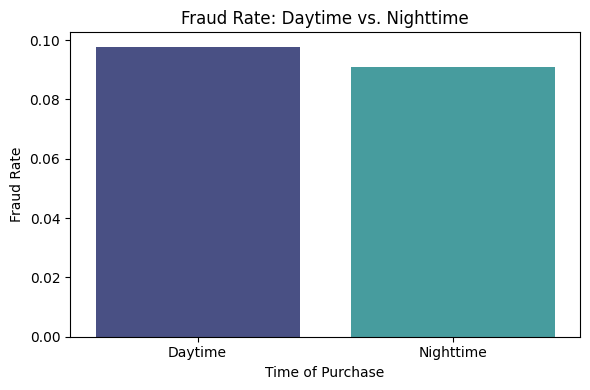

In [34]:
# Calculate fraud rate by time of day
fraud_night_day = fraud_data.groupby('is_night_purchase')['class'].mean()
fraud_night_day.index = ['Daytime', 'Nighttime']

# Plot
plt.figure(figsize=(6, 4))
sns.barplot(x=fraud_night_day.index, y=fraud_night_day.values, palette="mako")
plt.title("Fraud Rate: Daytime vs. Nighttime")
plt.ylabel("Fraud Rate")
plt.xlabel("Time of Purchase")
plt.tight_layout()
plt.show()


TRANSACTION FREQUENCY AND VELOCITY FEATURES

In [35]:
# === Sort by user and purchase time for velocity & frequency calculations ===
fraud_data = fraud_data.sort_values(['user_id', 'purchase_time'])

# === Transaction count per user ===
user_transaction_counts = fraud_data['user_id'].value_counts()
fraud_data['user_transaction_count'] = fraud_data['user_id'].map(user_transaction_counts)

# === Average purchase value per user ===
user_avg_purchase = fraud_data.groupby('user_id')['purchase_value'].mean()
fraud_data['user_avg_purchase_value'] = fraud_data['user_id'].map(user_avg_purchase)

# === Purchase value deviation from user average ===
fraud_data['purchase_value_deviation'] = (
    fraud_data['purchase_value'] - fraud_data['user_avg_purchase_value']
)

# === Transaction count per device ===
device_transaction_counts = fraud_data['device_id'].value_counts()
fraud_data['device_transaction_count'] = fraud_data['device_id'].map(device_transaction_counts)

# === Normalized transaction count per device (0–1 scale) ===
fraud_data['device_transaction_count_normalized'] = (
    fraud_data['device_transaction_count'] / device_transaction_counts.max()
)

# === Flag for most common device (e.g., Device 1 dominance) ===
most_common_device = device_transaction_counts.idxmax()
fraud_data['is_device_1'] = (fraud_data['device_id'] == most_common_device).astype(int)

# === Device activity grouping (e.g., High vs. Low activity) ===
fraud_data['device_activity_group'] = np.where(
    fraud_data['device_transaction_count'] > 10, 'High', 'Low'
)

# === Optional: One-hot encode device_activity_group ===
fraud_data = pd.get_dummies(fraud_data, columns=['device_activity_group'], drop_first=True)

# === Summary ===
print("✅ Transaction frequency features created!")
print(f"User transaction count stats:\n{fraud_data['user_transaction_count'].describe()}")
print(f"Device transaction count stats:\n{fraud_data['device_transaction_count'].describe()}")


✅ Transaction frequency features created!
User transaction count stats:
count    129146.0
mean          1.0
std           0.0
min           1.0
25%           1.0
50%           1.0
75%           1.0
max           1.0
Name: user_transaction_count, dtype: float64
Device transaction count stats:
count    129146.000000
mean          1.689669
std           2.653866
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          20.000000
Name: device_transaction_count, dtype: float64


In [36]:
top_devices = fraud_data['device_transaction_count'].value_counts().head(10)
print("Top 10 devices by transaction count:")
print(top_devices)


Top 10 devices by transaction count:
1     113812
2       7796
11       979
12       948
10       790
14       742
13       702
9        585
16       528
15       525
Name: device_transaction_count, dtype: int64


BEHAVIORAL FEATURES

In [37]:
# Create age groups
print("Creating age groups...")
def categorize_age(age):
    if age < 25:
        return 'Young'
    elif age < 45:
        return 'Middle'
    else:
        return 'Senior'

fraud_data['age_group'] = fraud_data['age'].apply(categorize_age)

# Create purchase value categories
print("Creating purchase value categories...")
fraud_data['purchase_value_category'] = pd.cut(
    fraud_data['purchase_value'], 
    bins=[0, 50, 200, 500, float('inf')], 
    labels=['Low', 'Medium', 'High', 'Very High']
)

# Check for weekend purchases
print("Creating weekend indicator...")
fraud_data['is_weekend'] = fraud_data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Check for night purchases (8PM to 6AM)
print("Creating night purchase indicator...")
fraud_data['is_night_purchase'] = fraud_data['hour_of_day'].apply(
    lambda x: 1 if x >= 20 or x <= 6 else 0
)

print("Behavioral features completed!")

Creating age groups...
Creating purchase value categories...
Creating weekend indicator...
Creating night purchase indicator...
Behavioral features completed!


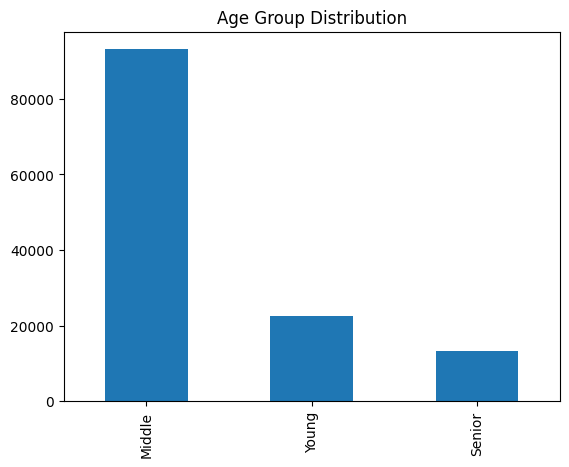

In [38]:
fraud_data['age_group'].value_counts().plot(kind='bar', title='Age Group Distribution')
plt.show()



 SAVE ENGINEERED FEATURES

In [40]:
# Remove low-importance features only if they exist
columns_to_drop = ['user_transaction_count', 'user_avg_purchase_value', 'purchase_value_deviation']
fraud_data.drop(columns=[col for col in columns_to_drop if col in fraud_data.columns], inplace=True)


# Display final feature summary
print("Final feature summary for fraud data:")
print(f"Total features: {len(fraud_data.columns)}")
print("New or reinforced features created:")
new_features = [
    'country_binned', 'hour_of_day_binned', 'is_night_purchase', 'is_peak_hour',
    'is_business_day', 'day_part', 'purchase_value_category', 'device_transaction_count_normalized',
    'is_device_1', 'device_activity_group'
]
for feature in new_features:
    print(f"  - {feature}")
print("Removed features:")
removed_features = ['user_transaction_count', 'user_avg_purchase_value', 'purchase_value_deviation']
for feature in removed_features:
    print(f"  - {feature}")

# Save the feature-engineered datasets
fraud_data.to_csv('fraud_data_with_features.csv', index=False)
creditcard_df.to_csv('creditcard_data_with_features.csv', index=False)

print("\nFeature engineering completed!")
print("Files saved:")
print("  - fraud_data_with_features.csv")
print("  - creditcard_data_with_features.csv")

# Display sample of engineered data
print("\nSample of engineered fraud data:")
print(fraud_data[['user_id', 'country_binned', 'hour_of_day_binned_Morning', 'time_since_signup', 
                  'is_night_purchase', 'is_peak_hour', 'is_business_day', 'day_part_Evening', 'class', 'is_device_1']].head())

Final feature summary for fraud data:
Total features: 45
New or reinforced features created:
  - country_binned
  - hour_of_day_binned
  - is_night_purchase
  - is_peak_hour
  - is_business_day
  - day_part
  - purchase_value_category
  - device_transaction_count_normalized
  - is_device_1
  - device_activity_group
Removed features:
  - user_transaction_count
  - user_avg_purchase_value
  - purchase_value_deviation

Feature engineering completed!
Files saved:
  - fraud_data_with_features.csv
  - creditcard_data_with_features.csv

Sample of engineered fraud data:
        user_id country_binned  hour_of_day_binned_Morning  \
31545         2  United States                           1   
97542         4          Other                           0   
12873         8  United States                           1   
104500       12          Other                           0   
21011        16  United States                           1   

        hour_of_day_binned_Morning  time_since_signup  is_

## 🔁 Feature Re-Engineering Summary

After conducting SHAP analysis and detecting a high number of **false negatives**, I revisited the feature engineering process to improve fraud detection performance and interpretability. The goal was to **enhance model signals** related to **time, behavior, and device usage**.

### 🎯 Why Re-engineer?
- SHAP analysis revealed **low-importance features** and **missing patterns** related to time and device activity.
- Specifically, features like `hour_of_day`, `is_night_purchase`, and `device_transaction_count` needed reinforcement.
- Some earlier features like `user_transaction_count` were **meaningless**, as every user made only one transaction.

---

### 🔍 Key Findings

- **Users:** Each user appears only once — rendering user-level stats like `user_avg_purchase_value` and `purchase_value_deviation` useless.
- **Devices:** Some devices were reused up to **20 times**. **Device 1** alone handled **~87%** of all transactions — a strong fraud signal.
- **Countries:** IPs are mapped correctly; most common: **United States**, **China**, **Japan**.
- **Time features** like `hour_of_day`, `is_night_purchase`, and `day_part` were crucial for SHAP-based explainability.

---

### ✅ Actions Taken

- **Dropped user-level features** (`user_transaction_count`, `purchase_value_deviation`, etc.)
- **Enhanced device-level features**, including:
  - `device_transaction_count_normalized`
  - `is_device_1` flag
  - `device_activity_group`
- **Reinforced time-based features**:
  - `is_peak_hour`, `is_night_purchase`, `is_business_day`, `day_part`
- **Added** purchase behavior flags like `purchase_value_category`

---

### 📦 Final Feature Engineering Summary

- **Total Features:** 45
- **New or Reinforced:** 10+
- **Files Saved:**
  - `fraud_data_with_features.csv`
  - `creditcard_data_with_features.csv`

> These improved features provide stronger signals for the model, reduce false negatives, and increase interpretability with SHAP.

